## Simulation plots

Code to make Figures 1-3 in main text and Supplemental Figures S2, S3, S5, S7 and S8. These are all based on pre-processed data from SAM simulations and ERA5 data obtained using the Copernicus toolkit

In [2]:
import numpy as np
import matplotlib.pylab as plt
import scipy.io as si
from matplotlib.ticker import MultipleLocator, FormatStrFormatter #to make the ticks nice
%matplotlib inline

In [3]:
#simulation names
sim3d_names = ["3D_channel_290K", "3D_channel_300K", "3D_channel_310K", "3D_channel_ElNino", "3D_channel_LaNina"]
l3d = len(sim3d_names)
sim2d_names = ["2D_channel_290K", "2D_channel_300K", "2D_channel_310K", "2D_channel_fixed_300K", "2D_channel_fixed_305K", \
               "2D_channel_fixed_310K", "2_moment_2D_channel_290K", "2_moment_2D_channel_300K", "2_moment_2D_channel_310K", \
               "2D_half_channel_300K", "2D_quarter_channel_300K", "uniform_u_2D_channel_300K", "shear_u_2D_channel_300K", \
               "nudging_10day_2D_channel_300K", "nudging_10day_2D_channel_305K", "uniform_u_2D_channel_305K", "shear_u_2D_channel_305K"]
l2d = len(sim2d_names)
era_names = ["ERA_mean", "ERA_Jan_2006", "ERA_Jun_2006"]

In [4]:
#SAM dimensions
press = np.load( "3d_data/SAM_press.dat" )
p = len(press)
z = np.load( "3d_data/SAM_z.dat" )

d3 = 4096 #number of 3D grid points
d2 = d3 * 2 #number of 2D grid points

y3d = np.linspace( 0, d3 * 3. / 1000., d3 )
y2d = np.linspace( 0, d2 * 3 / 1000., d2 )

In [5]:
#arrays for storing initial data
rh_3d = np.zeros( ( ( l3d, p, d3 ) ) )
t_3d = np.zeros( ( ( l3d, p, d3 ) ) )
u_3d = np.zeros( ( ( l3d, p, d3 ) ) )
Q_3d = np.zeros( ( ( 3, p, d3 ) ) ) #only want these for three channel 3D runs
w_3d = np.zeros( ( ( 3, p, d3 ) ) ) #only want these for three channel 3D runs

rh_2d = np.zeros( ( ( l2d, p, d2 ) ) )
t_2d = np.zeros( ( ( l2d, p, d2 ) ) )
u_2d = np.zeros( ( ( l2d, p, d2 ) ) )

In [6]:
#Load 3d and 2d data
for i in range(l3d):
    rh_3d[i] = np.load("3d_data/" + sim3d_names[i] + "_relh.dat")
    t_3d[i] = np.load("3d_data/" + sim3d_names[i] + "_temp.dat")
    u_3d[i] = np.load("3d_data/" + sim3d_names[i] + "_U.dat")
    if i < 3: #don't need radiative cooling or w from ENSO simulations
        Q_3d[i] = np.load("3d_data/" + sim3d_names[i] + "_QRAD.dat")
        w_3d[i] = np.load("3d_data/" + sim3d_names[i] + "_W.dat")

for i in range(9):
    rh_2d[i] = np.load("2d_data/" + sim2d_names[i] + "_relh.dat")
    t_2d[i] = np.load("2d_data/" + sim2d_names[i] + "_temp.dat")
    u_2d[i] = np.load("2d_data/" + sim2d_names[i] + "_U.dat")


In [7]:
def streamfunction( u, p ):
    #function for calculating overturning streamfunction using zonal wind
	d1, d2 = np.shape( u )
	s = np.zeros( ( d1, d2 ) )

	for i in range( 1, d1 ):
		s[ i, :] += np.trapz( u[:i, :], p[:i], axis = 0 )

	return s / 9.8

In [9]:
#Load preprocessed ERA5 data
era_rh = np.load("ERA5_data/ERA_Jan_2006_RH.dat")
era_rh2 = np.load("ERA5_data/ERA_mean_RH.dat")
era_rh3 = np.load("ERA5_data/ERA_Jun_2006_RH.dat")

erw = np.load("ERA5_data/ERA_Jan_2006_total_W.dat")
erw2 = np.load("ERA5_data/ERA_mean_total_W.dat")
erw3 = np.load("ERA5_data/ERA_Jun_2006_total_W.dat")

#ERA5 dimensions
era_press = np.load("ERA5_data/ERA_press.dat") / 100.
era_p = len(era_press)

era_lats = np.load("ERA5_data/ERA_lats.dat")
era_lons = np.load("ERA5_data/ERA_lons.dat")
rad_lons = era_lons * np.pi / 180.
rsphere = 6.37122e6

#grab 5S to 5N, can easily change to 0-10 or 10-0.
era_l = np.where(abs(era_lats) < 5.)

#grab longitude range
era_ll = np.where( (era_lons >= 140.) & (era_lons < 270.))

In [10]:
def streamfunction2( w, x ):
    #calculate era5 streamfunction using W rather than U, so can substract off mean
    
	d1, d2 = np.shape( w )
	s = np.zeros( ( d1, d2 ) )

	for i in range( d2):
		s[ :, i] += np.trapz( w[:, :i], x[:i], axis = 1 )

	return -s / 9.8

era_stream = np.zeros( ( (3, era_p, len(era_ll[0]) )))
era_RH = np.zeros( ( (3, era_p, len(era_ll[0]) )))

#calculate streamfunctions, subtracting off zonal-mean
W = np.mean(erw[:, era_l[0],:], axis = 1)
W = W[:, era_ll[0]]
W2 = np.mean(erw2[:, era_l[0],:], axis = 1)
W2 = W2[:, era_ll[0]]
W3 = np.mean(erw3[:, era_l[0],:], axis = 1)
W3 = W3[:, era_ll[0]]

era_stream[0] = streamfunction2( W - np.mean(W, axis = 1)[:, np.newaxis], rad_lons )
era_stream[0] *= rsphere
era_stream[1] = streamfunction2( W2 - np.mean(W2, axis = 1)[:, np.newaxis], rad_lons )
era_stream[1] *= rsphere
era_stream[2] = streamfunction2( W3 - np.mean(W3, axis = 1)[:, np.newaxis], rad_lons )
era_stream[2] *= rsphere

era_rh = np.mean( era_rh[:, era_l[0], :], axis = 1)
era_RH[0] = era_rh[:, era_ll[0]]
era_rh2 = np.mean( era_rh2[:, era_l[0], :], axis = 1)
era_RH[1] = era_rh2[:, era_ll[0]]
era_rh3 = np.mean( era_rh3[:, era_l[0], :], axis = 1)
era_RH[2] = era_rh3[:, era_ll[0]]

In [11]:
def make_axis_contour(ax, i, y):
    #for plotting
    plt.ylim([1000., 10.])

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
            
    majorLocator = MultipleLocator(200)
    ax.yaxis.set_major_locator(majorLocator)
    majorLocator = MultipleLocator(3)
    ax.xaxis.set_major_locator(majorLocator)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)

    
    ax.tick_params(length = 5, which = 'both')
    ax.tick_params(which='both', width=2)

    if i == 2:
        plt.xlabel("x [10$^3$km]", fontsize = 18)
    else:
        plt.xticks(color='w', fontsize = 0.)
    if y == 1:
        plt.ylabel("pressure [hPa]", fontsize = 18)
    else:
        plt.yticks(color='w', fontsize = 0.)

    return 

## Figure 1

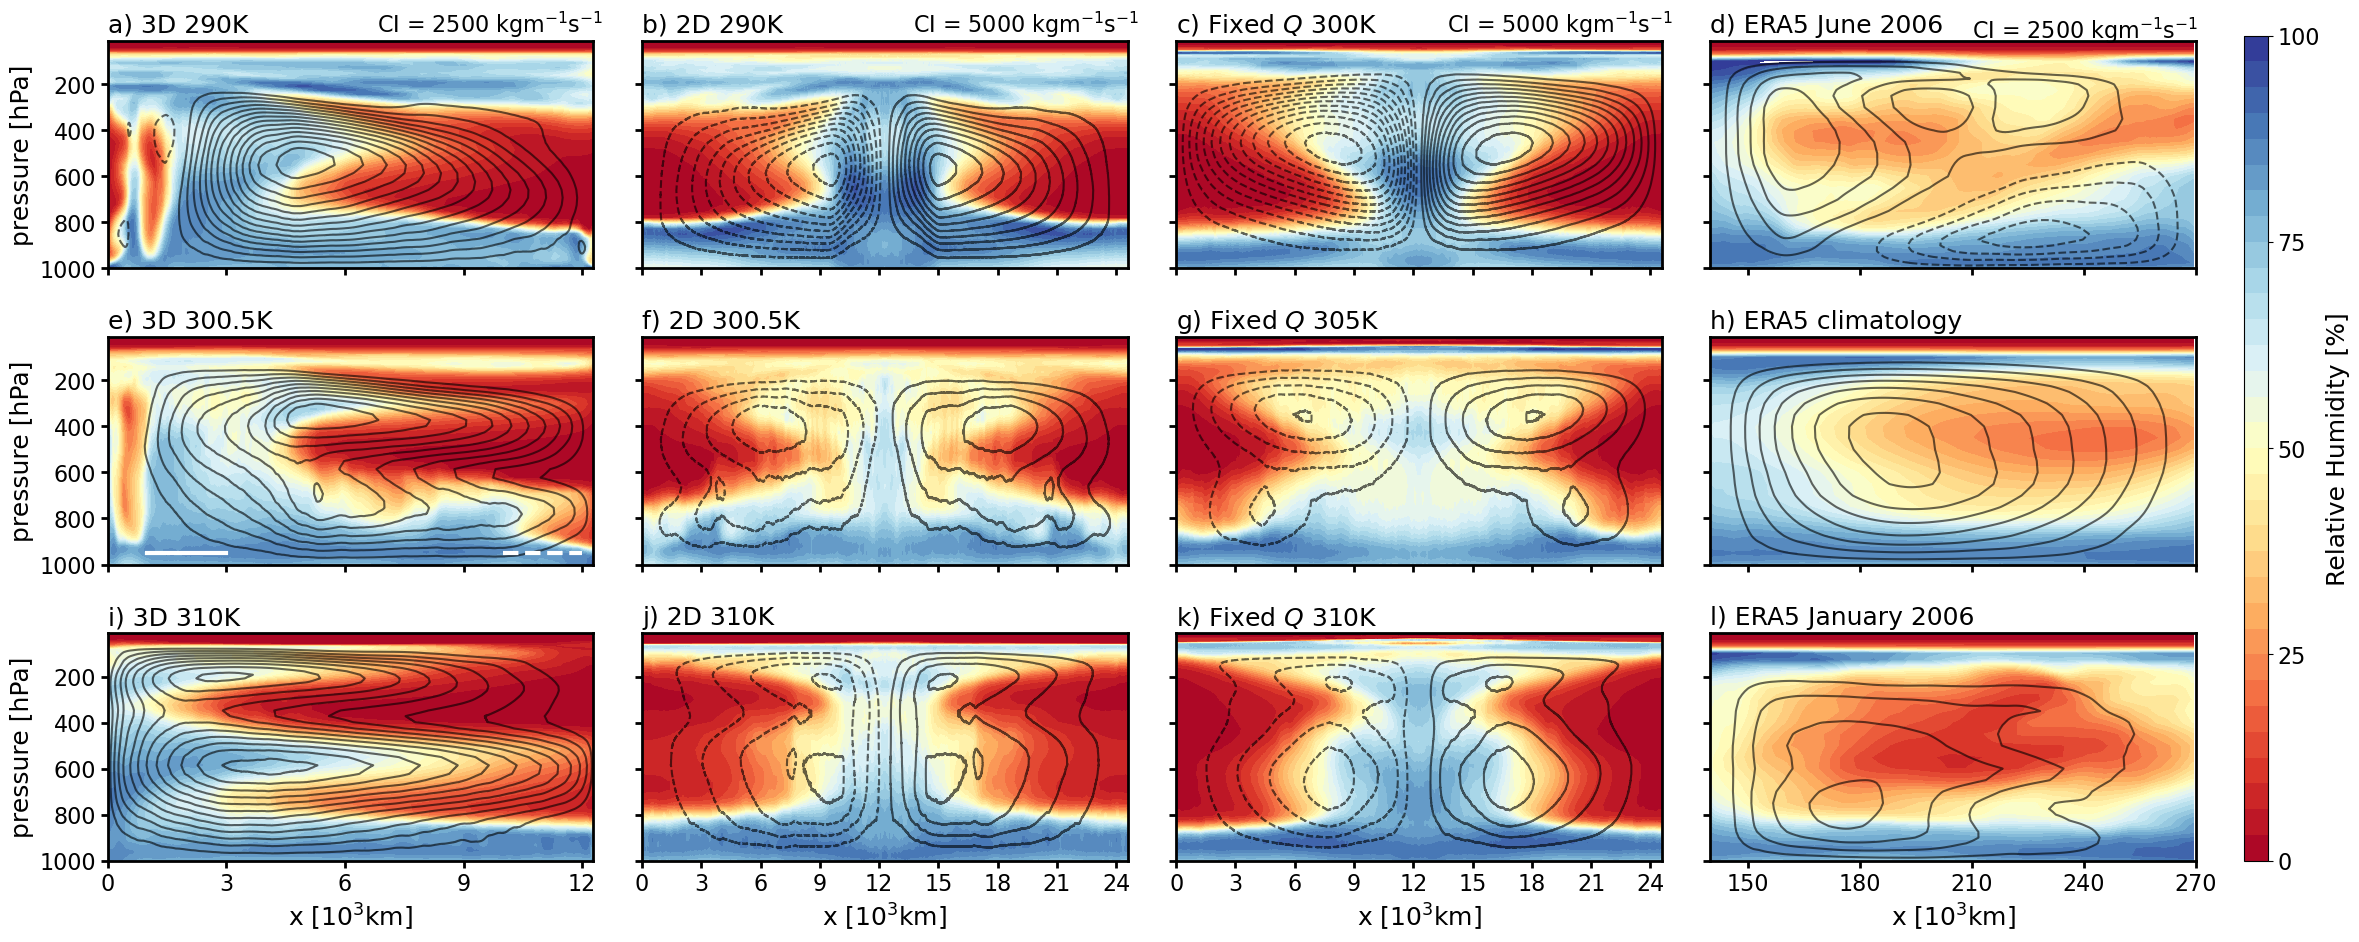

In [12]:
fig = plt.figure( figsize = (24, 10) )
plt.subplots_adjust(left = 0.05, right = 0.98, bottom = 0.12, top = 0.94, hspace = 0.3, wspace = 0.1)

titles = ["a) 3D 290K", "e) 3D 300.5K", "i) 3D 310K", 
          "b) 2D 290K", "f) 2D 300.5K", "j) 2D 310K",
          "c) Fixed $Q$ 300K", "g) Fixed $Q$ 305K", "k) Fixed $Q$ 310K",
          "d) ERA5 June 2006", "h) ERA5 climatology", "l) ERA5 January 2006"]

for i in range( 3 ):
    #plot 3d cases
    ax = plt.subplot(3, 4, 1 + i * 4)
    plt.title( titles[i], fontsize = 18, loc = "left" )

    rh_levels = np.linspace( 0., 100., 33 )
    plt.contourf( y3d, press , rh_3d[i] * 100., rh_levels, cmap = plt.cm.RdYlBu )

    stream = streamfunction( u_3d[i], press * 100. )
    #sstream = streamfunction( u_3d[i] * -rho[:, np.newaxis] * 9.8, y3d * 10. ** 6 )
    str_levs = np.arange(-50000., 52500, 2500 )
    str_levs = str_levs[str_levs != 0]
    plt.contour( y3d, press, stream, str_levs, colors = 'k', alpha = 0.6 )
    
    plt.ylim([1000., 10.])
    #Show warm pool and cold pool
    if i == 1:
        wp = [1., 3.]
        plt.plot( wp, [950., 950.], 'w', linewidth = 3.)
        cp = [10., 12.]
        plt.plot( cp, [950., 950.], 'w--', linewidth = 3.)

    if i == 0:
        plt.text( 6.8, -25., "CI = 2500 kgm$^{-1}$s$^{-1}$", fontsize = 16 )

    make_axis_contour(ax, i, 1)

for i in range( 3 ):
    #plot 2d cases
    ax = plt.subplot(3, 4, 2 + i * 4)
    plt.title( titles[i + 3], fontsize = 18, loc = "left" )

    #symmetrize RH
    rh_2d[i] = (rh_2d[i] + rh_2d[i, :, ::-1]) / 2.
    plt.contourf( y2d, press , rh_2d[i, :, :], rh_levels, cmap = plt.cm.RdYlBu )
    
    stream = streamfunction( u_2d[i], press * 100. )
    #symmetrize streamfunction
    stream = (stream - stream[:, ::-1]) / 2.
    
    str_levs = np.arange(-100000., 105000, 5000. )
    str_levs = str_levs[str_levs != 0]
    plt.contour( y2d , press, stream[:, :], str_levs, colors = 'k', alpha = 0.6 )
    
    if i == 0:
        plt.text( 13.7, -25., "CI = 5000 kgm$^{-1}$s$^{-1}$", fontsize = 16 )
    make_axis_contour(ax, i, 0)



for i in range( 3 ):
    #plot 2d cases with fixed radiative cooling
    ax = plt.subplot(3, 4, 3 + i * 4)
    plt.title( titles[i + 6], fontsize = 18, loc = "left" )

    #symmetrize RH    
    rh_2d[3 + i] = (rh_2d[3 + i] + rh_2d[3 + i, :, ::-1]) / 2.
    plt.contourf( y2d, press , rh_2d[3 + i], rh_levels, cmap = plt.cm.RdYlBu )
    
    stream = streamfunction( u_2d[3 + i], press * 100. )
    stream = (stream - stream[:, ::-1]) / 2.
    plt.contour( y2d, press, stream, str_levs, colors = 'k', alpha = 0.6 )

    plt.ylim([1000., 10.])
    if i == 0:
        plt.text( 13.7, -25., "CI = 5000 kgm$^{-1}$s$^{-1}$", fontsize = 16 )
    make_axis_contour(ax, i, 0)

for i in range( 3 ):
    #plot reanalysis data
    ax = plt.subplot(3, 4, 4 + i * 4)
    plt.title( titles[i + 9], fontsize = 18, loc = "left" )

    cset = plt.contourf( era_lons[era_ll], era_press , era_RH[i], rh_levels, cmap = plt.cm.RdYlBu )
    str_levs = np.arange(-20000., 25000, 2500. )
    str_levs = str_levs[str_levs != 0]
    plt.contour( era_lons[era_ll], era_press, era_stream[i], str_levs, colors = 'k', alpha = 0.6)
    if i == 0:
        plt.text( 210., 0., "CI = 2500 kgm$^{-1}$s$^{-1}$", fontsize = 16 )
        
    make_axis_contour(ax, i, 0)
    #adjust x ticks
    majorLocator = MultipleLocator(30)
    ax.xaxis.set_major_locator(majorLocator)
    plt.xlim([140., 270.])

fig.subplots_adjust(right = 0.92)
cbar_ax = fig.add_axes([0.94, 0.12, 0.01, 0.825])
cb = fig.colorbar(cset, cax=cbar_ax, ticks = [0., 25., 50., 75., 100.])
cb.set_label( "Relative Humidity [%]", fontsize = 18  )
cb.ax.tick_params(labelsize=16)


#plt.savefig("MW_overturning_plot.pdf")
#plt.savefig("MW_overturning_plot.png")

now make figure 2

In [14]:
#define cold pool
cold_pool = np.where( (y3d >= 10) & (y3d <=12.))

#some constant we'll need
cp = 1005.
day = 86400.

#need density to convert w to omega
rho = np.zeros( ( 3, p))
temps = ["290", "300", "310"]
for i in range( 3 ):
    rho[i] = np.load("3d_data/3D_channel_" + temps[i] + "K_rho.dat")

In [20]:
#now calculate stability using forward differencing
stability = np.zeros( ( 3, p - 1 ) )

for i in range( 3 ):
    d = cp * np.mean(t_3d[i, :, cold_pool[:]], axis = 1) + 9.8 * z
    stability[i] = -(d[0, 1:] - d[0, :-1])/ (press[1:] - press[:-1]) / 100.

In [21]:
#Plotting stuff

cs = [(31 / 255., 119 / 255., 180 / 255.), (44. / 255., 160 / 255., 44 / 255.), (214 / 255., 39 / 255., 40 / 255.), 
      (255 / 255., 127 / 255., 14 / 255.) ] #colorblind friendly color scheme

def make_axis( a):
    majorLocator = MultipleLocator( 200 )
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator( 100 )

    a.yaxis.set_major_locator(majorLocator)
    a.yaxis.set_major_formatter(majorFormatter)
    a.yaxis.set_minor_locator(minorLocator)
    
    plt.yticks(fontsize = 16)    
    plt.ylim([1000., 25.])
    
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    
    for axis in ['top','bottom','left','right']:
        a.spines[axis].set_linewidth(2)
    a.tick_params(which='minor', width=4)
    a.tick_params(which='major', length= 5)
    a.tick_params(which='both', width=2)

    return 0

## Figure 2

(-1.0, 8.0)

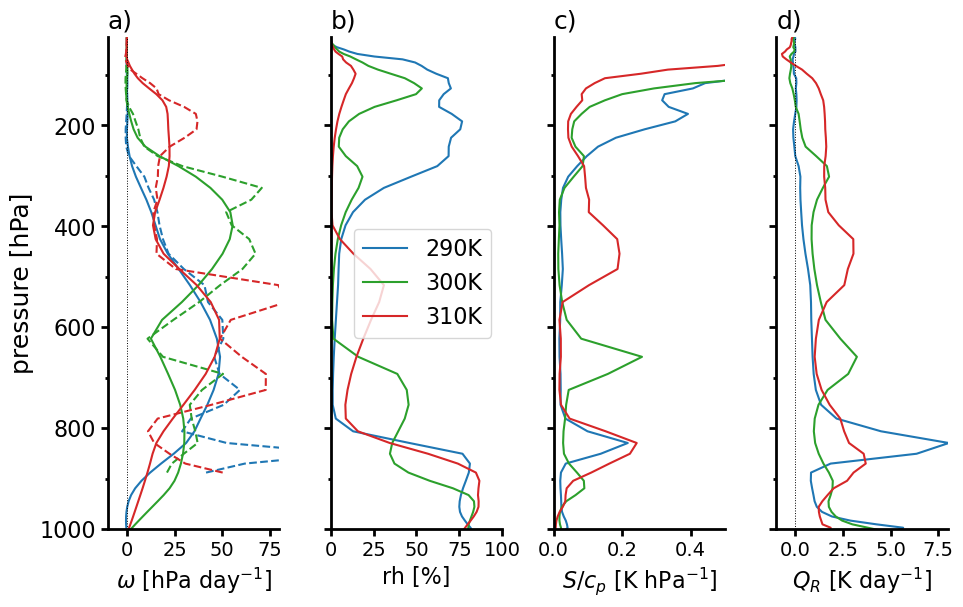

In [22]:
fig = plt.figure( figsize = (10, 6) )
plt.subplots_adjust(left = 0.11, right = 0.95, bottom = 0.12, top = 0.94, hspace = 0.4, wspace = 0.3)


ax = plt.subplot(1, 4, 1)
plt.title("a)", loc = 'left', fontsize = 18)
#pressure velocities
for i in range( 3 ):
    plt.plot( np.mean(w_3d[i, :, cold_pool[0]], axis = 0) * -9.8 * rho[i] / 100. * day, press, color = cs[i])

    #now add WTG velocities. make sure stability and Q correspond to interface values
    nrad_d = np.mean((Q_3d[i, 1:, cold_pool[0] ] + Q_3d[i, :-1, cold_pool[0]]) / 2., axis = 0)
    wtg = nrad_d / stability[i, :]
    plt.plot( -wtg[11:] * cp / 100., press[12:], '--', color = cs[i])


make_axis( ax )
plt.ylabel("pressure [hPa]", fontsize = 18)
plt.axvline(x = 0., color ='k', linestyle = ":", linewidth = 0.7)
plt.xticks(fontsize = 14)
plt.xlabel("$\omega$ [hPa day$^{-1}$]", fontsize = 16) 
plt.xlim([-10., 80.])

ax = plt.subplot(1, 4, 2)
plt.title("b)", loc = 'left', fontsize = 18)

#relative humidities
for i in range( 3 ):
    plt.plot( np.mean(rh_3d[i, :, cold_pool[0]], axis = 0) * 100., press, color = cs[i])

make_axis( ax )
plt.yticks(color = "w", fontsize = 0.)
plt.xticks(fontsize = 14)
plt.xlabel("rh [%]", fontsize = 16) 
plt.xlim([0., 100.])

plt.legend(["290K", "300K", "310K"], loc = "center right", fontsize = 16)

ax = plt.subplot(1, 4, 3)
plt.title("c)", loc = 'left', fontsize = 18)

#stabilities
for i in range( 3 ):
    plt.plot( stability[i] * 100. / 1005., press[:-1], color = cs[i])

make_axis( ax )
plt.yticks(color = "w", fontsize = 0.)
plt.xticks(fontsize = 14)
plt.xlabel("$S / c_p$ [K hPa$^{-1}$]", fontsize = 16) 
plt.xlim([0., 0.5])

ax = plt.subplot(1, 4, 4)
plt.title("d)", loc = 'left', fontsize = 18)

#radiative cooling. Note minus sign
for i in range( 3 ):
    plt.plot( -np.mean(Q_3d[i, :, cold_pool[0]], axis = 0), press, color = cs[i])

make_axis( ax )
plt.yticks(color = "w", fontsize = 0.)
plt.axvline(x = 0., color ='k', linestyle = ":", linewidth = 0.7)
plt.xticks(fontsize = 14)
plt.xlabel("$Q_R$ [K day$^{-1}$]", fontsize = 16) 
plt.xlim([-1., 8.])

#plt.savefig("EP_profiles.pdf")
#plt.savefig("EP_profiles.png")

## Supplemental Figure S2
double-moment simulations

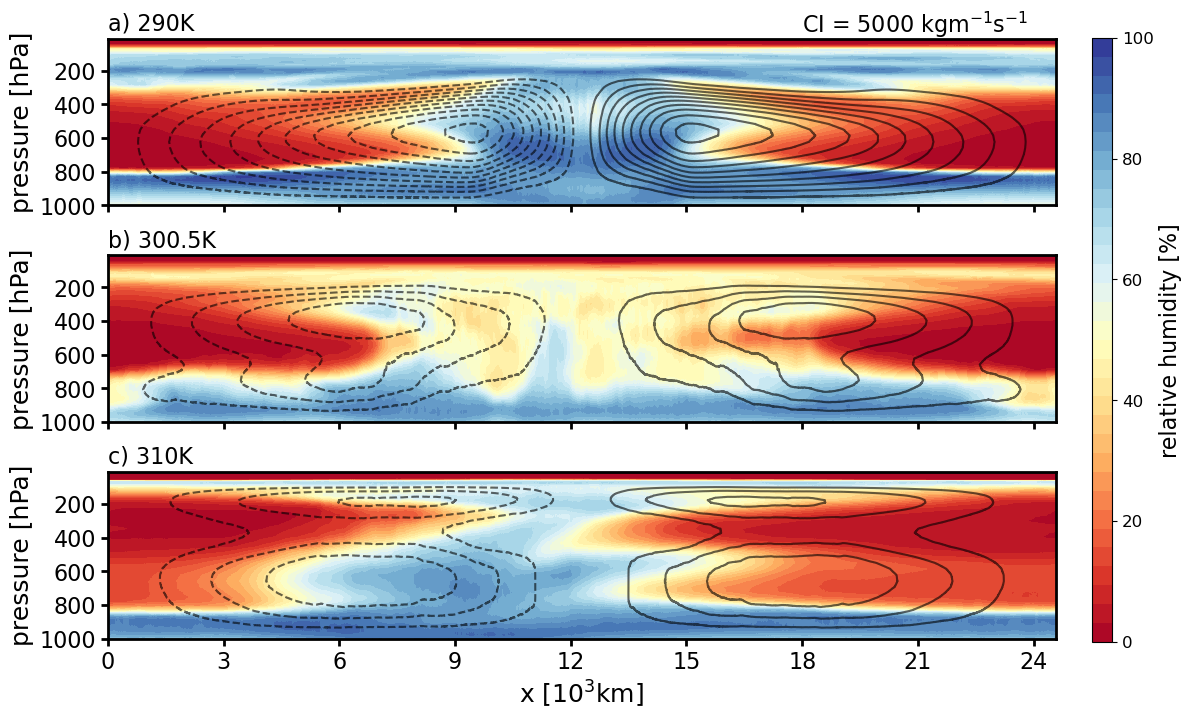

In [23]:
fig = plt.figure( figsize = (12, 8) )
plt.subplots_adjust(left = 0.1, right = 0.98, bottom = 0.17, top = 0.92, hspace = .3, wspace = 1.)

titles = ["a) 290K", "b) 300.5K", "c) 310K"]

for i in range( 3 ):
    ax = plt.subplot(3, 1, 1 + i)
    plt.title( titles[i], loc = "left", fontsize = 16)

    #symmetrize RH
    rh_2d[i] = (rh_2d[6 + i] + rh_2d[6 + i, :, ::-1]) / 2.
    plt.contourf( y2d, press , rh_2d[6 + i, :, :], rh_levels, cmap = plt.cm.RdYlBu )
    
    stream = streamfunction( u_2d[6 + i], press * 100. )
    #symmetrize streamfunction
    stream = (stream - stream[:, ::-1]) / 2.
    
    str_levs = np.arange(-100000., 105000, 5000. )
    str_levs = str_levs[str_levs != 0]
    plt.contour( y2d , press, stream[:, :], str_levs, colors = 'k', alpha = 0.6 )
    
    if i == 0:
        plt.text( 18, -25., "CI = 5000 kgm$^{-1}$s$^{-1}$", fontsize = 16 )
    make_axis_contour(ax, i, 1)


fig.subplots_adjust(right = 0.89)

cbar_ax = fig.add_axes([0.92, 0.166, 0.017, 0.755])
cb = fig.colorbar(cset, cax=cbar_ax, ticks = [0., 20., 40., 60., 80., 100.])
cb.set_label( "relative humidity [%]", fontsize = 16)
cb.ax.tick_params(labelsize=12)

#plt.savefig("SAM_circulation_2_moment.pdf")
#plt.savefig("SAM_circulation_2_moment.png")

## Supplemental Figure S3
3D ENSO plots

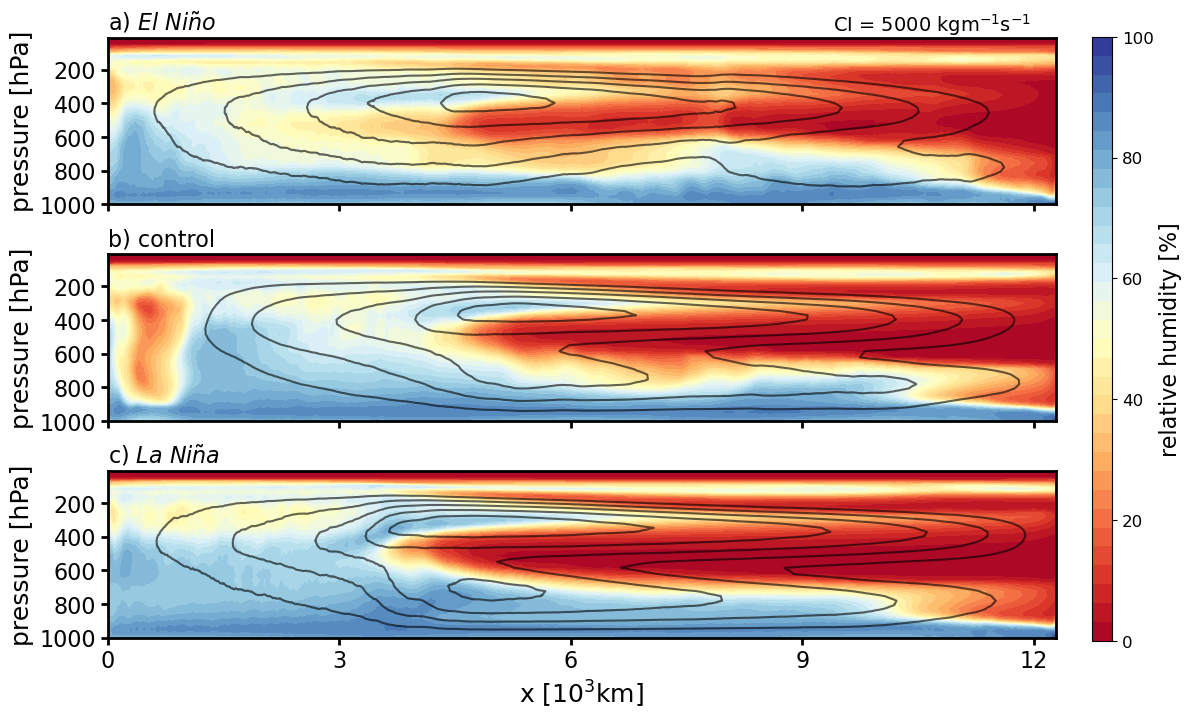

In [24]:
fig = plt.figure( figsize = (12, 8) )
plt.subplots_adjust(left = 0.1, right = 0.98, bottom = 0.17, top = 0.92, hspace = .3, wspace = 1.)

titles = ["a) $El$ $Ni\~no$", "b) control", "c) $La$ $Ni\~na$"]

a = [3, 1, 4] #ordering of simulations in array
for i in range( 3 ):
    ax = plt.subplot(3, 1, 1 + i)
    plt.title( titles[i], loc = "left", fontsize = 16)

    plt.contourf( y3d, press , rh_3d[a[i], :, :] * 100., rh_levels, cmap = plt.cm.RdYlBu )
    
    stream = streamfunction( u_3d[a[i]], press * 100. )

    str_levs = np.arange(-100000., 105000, 5000. )
    str_levs = str_levs[str_levs != 0]
    plt.contour( y3d , press, stream[:, :], str_levs, colors = 'k', alpha = 0.6 )
    
    if i == 0:
        plt.text( 9.4, -30., "CI = 5000 kgm$^{-1}$s$^{-1}$", fontsize = 14 )

    make_axis_contour(ax, i, 1)

fig.subplots_adjust(right = 0.89)

cbar_ax = fig.add_axes([0.92, 0.166, 0.017, 0.755])
cb = fig.colorbar(cset, cax=cbar_ax, ticks = [0., 20., 40., 60., 80., 100.])
cb.set_label( "relative humidity [%]", fontsize = 16)
cb.ax.tick_params(labelsize=12)

#plt.savefig("SAM_circulation_ENSO.pdf")
#plt.savefig("SAM_circulation_ENSO.png")

# Figure 3

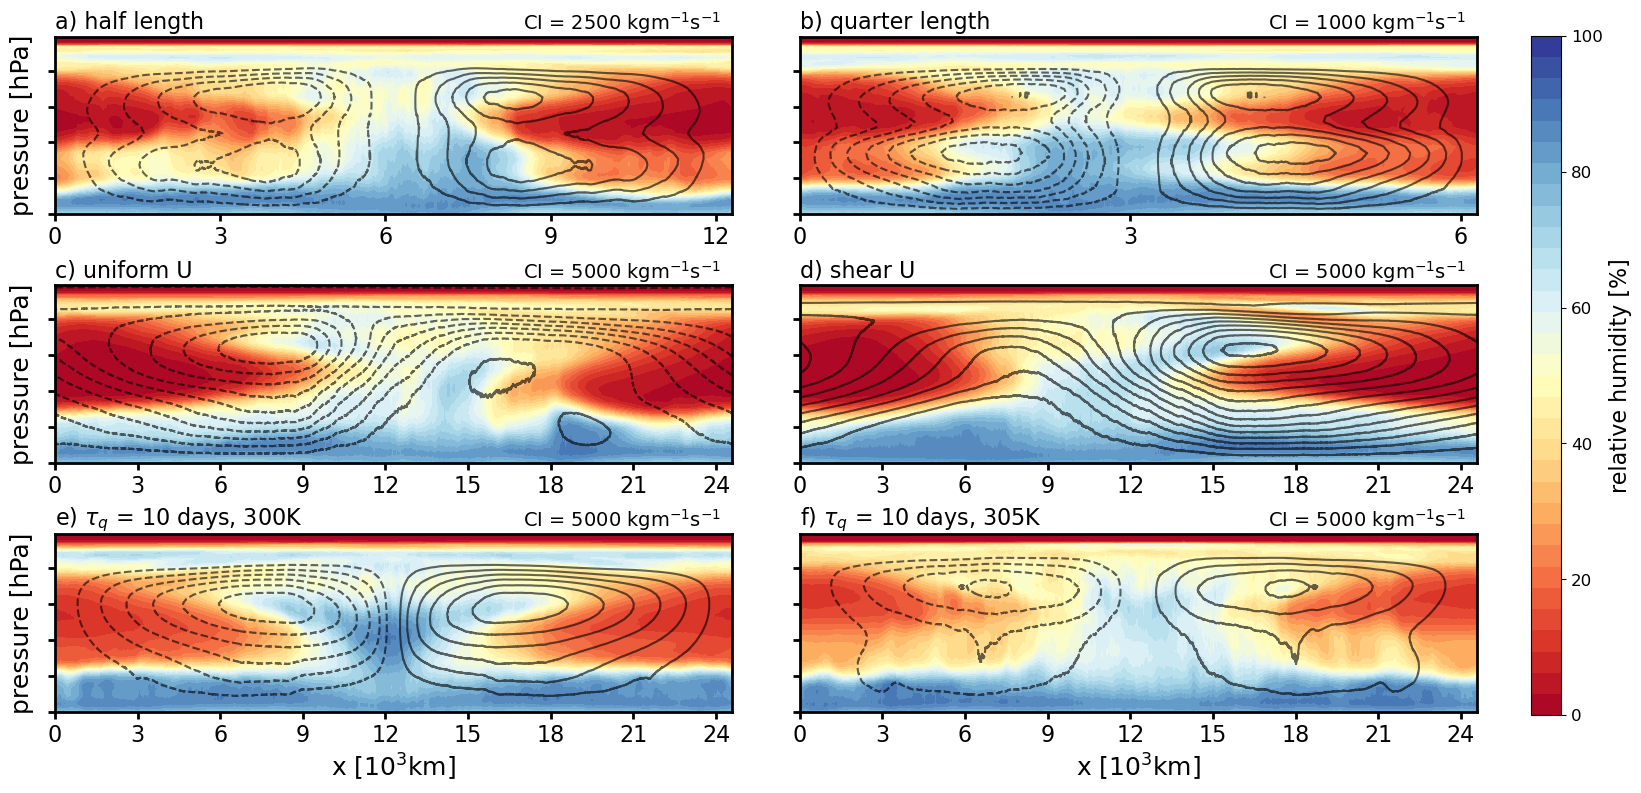

In [25]:
fig = plt.figure( figsize = (18, 9) )
plt.subplots_adjust(left = 0.1, right = 0.98, bottom = 0.17, top = 0.92, hspace = .4, wspace = .1)

#like Figure 1 but we'll have to load some data. Since the data have different dimensions in some cases can't load everything at once
titles = ["a) half length", "b) quarter length", "c) uniform U", "d) shear U", "e) $\\tau_q$ = 10 days, 300K",\
          "f) $\\tau_q$ = 10 days, 305K"]

for i in range( 6 ):
    ax = plt.subplot(3, 2, 1 + i)
    plt.title( titles[i], loc = "left", fontsize = 16)
    
    rh_2d = np.load("2d_data/" + sim2d_names[9 + i] + "_relh.dat")
    u_2d = np.load("2d_data/" + sim2d_names[9 + i] + "_U.dat")

    d1, d2 = np.shape(u_2d)    
    y = np.linspace(0., d2 * 3., d2) / 1000. 
        
    plt.contourf( y, press , rh_2d[:, :], rh_levels, cmap = plt.cm.RdYlBu )
    
    stream = streamfunction( u_2d, press * 100. )
    #symmetrize streamfunction except when have mean shear
    if i != 2 and i != 3:
        stream = (stream - stream[:, ::-1]) / 2.

    #adjust contours
    if i == 0:
        str_levs = np.arange(-10000., 15000, 2500. )
    elif i == 1:
        str_levs = np.arange(-10000., 15000, 1000. )
    else:
        str_levs = np.arange(-100000., 105000, 5000. )
    str_levs = str_levs[str_levs != 0]
    
    plt.contour( y , press, stream[:, :], str_levs, colors = 'k', alpha = 0.6 )
    
    if i == 0:
        plt.text( 17. / 2., -30., "CI = 2500 kgm$^{-1}$s$^{-1}$", fontsize = 14 )
    elif i == 1:
        plt.text( 17. / 4., -30., "CI = 1000 kgm$^{-1}$s$^{-1}$", fontsize = 14 )
    else:
        plt.text( 17., -30., "CI = 5000 kgm$^{-1}$s$^{-1}$", fontsize = 14 )
    make_axis_contour(ax, 2, 0)
    
    if i > 3:
        plt.xlabel("x [10$^3$km]", fontsize = 18)
    else:
        plt.xlabel("")
    if i %2 == 0:
        plt.ylabel("pressure [hPa]", fontsize = 18)
    else:
        plt.yticks(color='w')

fig.subplots_adjust(right = 0.89)

cbar_ax = fig.add_axes([0.92, 0.166, 0.017, 0.755])
cb = fig.colorbar(cset, cax=cbar_ax, ticks = [0., 20., 40., 60., 80., 100.])
cb.set_label( "relative humidity [%]", fontsize = 16)
cb.ax.tick_params(labelsize=12)

#plt.savefig("SAM_circulation_length.pdf")
#plt.savefig("SAM_circulation_length.png")

## Supplemental Figure S5
specific humidity over the cold pools

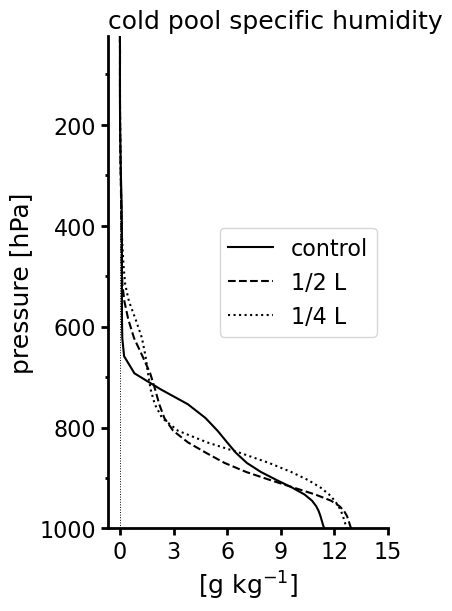

In [27]:
fig = plt.figure( figsize = (4, 6) )
plt.subplots_adjust(left = 0.25, right = 0.95, bottom = 0.12, top = 0.94, hspace = 0.4, wspace = 0.3)

q = np.load( "2d_data/2D_channel_300K_qv.dat" )
q2 = np.load( "2d_data/2D_half_channel_300K_qv.dat" )
q3 = np.load( "2d_data/2D_quarter_channel_300K_qv.dat" )

ax = plt.subplot(1, 1, 1)
plt.title("cold pool specific humidity", loc = 'left', fontsize = 18)

plt.plot( np.mean(q[:, 2 * cold_pool[0]], axis = 1), press, 'k')
plt.plot( np.mean(q2[:, cold_pool[0]], axis = 1), press, 'k--')
plt.plot( np.mean(q3[:, cold_pool[0] // 2], axis = 1), press, 'k:')

make_axis( ax )
plt.ylabel("pressure [hPa]", fontsize = 18)
plt.axvline(x = 0., color ='k', linestyle = ":", linewidth = 0.7)
plt.xticks([0., 3., 6., 9., 12., 15.], fontsize = 16)
plt.xlabel("[g kg$^{-1}$]", fontsize = 18.)

plt.legend(["control", "1/2 L", "1/4 L"], loc = "center right", fontsize = 16)

#plt.savefig("coldpool_SH.pdf")
#plt.savefig("coldpool_SH.png")


## Supplemental Figure S7
Simulations with mean winds and warmer SSTs

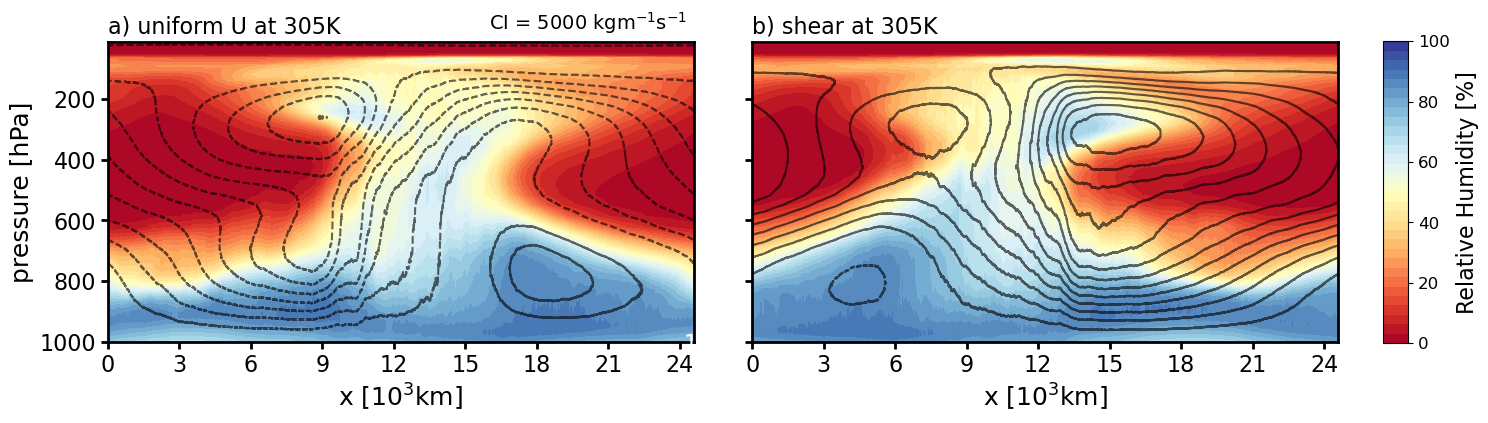

In [368]:
fig = plt.figure( figsize = (15, 4) )
plt.subplots_adjust(left = 0.07, right = 0.98, bottom = 0.17, top = 0.92, hspace = .4, wspace = .1)

titles = ["a) uniform U at 305K", "b) shear at 305K"]
for i in range( 2 ):
    ax = plt.subplot(1, 2, 1 + i)
    plt.title( titles[i], loc = "left", fontsize = 16)
    
    rh_2d = np.load("2d_data/" + sim2d_names[15 + i] + "_relh.dat")
    u_2d = np.load("2d_data/" + sim2d_names[15 + i] + "_U.dat")

    d1, d2 = np.shape(u_2d)    
    y = np.linspace(0., d2 * 3., d2) / 1000. 
        
    plt.contourf( y, press , rh_2d[:, :], rh_levels, cmap = plt.cm.RdYlBu )
    
    stream = streamfunction( u_2d, press * 100. )

    str_levs = np.arange(-100000., 105000, 5000. )
    str_levs = str_levs[str_levs != 0]
    
    plt.contour( y , press, stream[:, :], str_levs, colors = 'k', alpha = 0.6 )
    
    if i == 0:
        plt.text( 16., -30., "CI = 5000 kgm$^{-1}$s$^{-1}$", fontsize = 14 )
    make_axis_contour(ax, 2, 1)
    
    if i %2 == 0:
        plt.ylabel("pressure [hPa]", fontsize = 18)
    else:
        plt.ylabel("")
        plt.yticks(color='w')
    plt.xlabel("x [10$^3$km]", fontsize = 18)
fig.subplots_adjust(right = 0.89)

cbar_ax = fig.add_axes([0.92, 0.166, 0.017, 0.755])
cb = fig.colorbar(cset, cax=cbar_ax, ticks = [0., 20., 40., 60., 80., 100.])
cb.set_label( "Relative Humidity [%]", fontsize = 16)
cb.ax.tick_params(labelsize=12)

#plt.savefig("SAM_circulation_meanU.pdf")
#plt.savefig("SAM_circulation_meanU.png")

## Supplemental Figure S8
Compare RH cross-sections in control simulation and moisture source simulations

516.63385


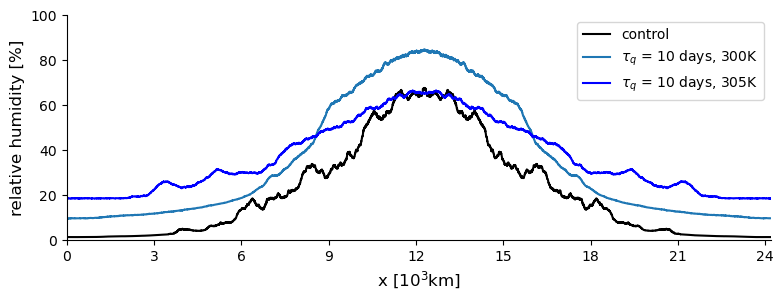

In [377]:
fig = plt.figure( figsize = (8, 3) )
plt.subplots_adjust(left = 0.1, right = 0.98, bottom = 0.17, top = 0.92, hspace = .4, wspace = .1)

level = 25
print(press[level])

ax = plt.subplot(1, 1, 1)
for i in range(3):

    if i == 0:
        rh = np.load( "2d_data/2d_channel_300K_relh.dat")
        rh = (rh[:, ] + rh[:, ::-1])/2.
        plt.plot(y2d, rh[level], color = 'k')
    elif i == 1:
        rh = np.load( "2d_data/nudging_10day_2D_channel_300K_relh.dat")
        rh = (rh[:, ] + rh[:, ::-1])/2.
        plt.plot(y2d, rh[level], color = cs[0])
    else:
        rh = np.load( "2d_data/nudging_10day_2D_channel_305K_relh.dat")
        rh = (rh[:, ] + rh[:, ::-1])/2.
        plt.plot(y2d, rh[level], color = 'b')

plt.legend(["control", "$\\tau_q$ = 10 days, 300K", "$\\tau_q$ = 10 days, 305K"])

plt.ylabel("relative humidity [%]", fontsize = 12)
plt.xlabel("x [10$^3$km]", fontsize = 12)
plt.xlim([0., 24.2])
plt.ylim([0., 100.])
plt.xticks([0., 3., 6., 9., 12., 15., 18., 21., 24.])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.savefig("moisture_RH_profiles.pdf")
#plt.savefig("moisture_RH_profiles.png")